# Car Claim Insurance Prediction 🚓

### Introduction
Dataset: https://www.kaggle.com/datasets/xiaomengsun/car-insurance-claim-data

The data includes around 8000 records of car insurance policyholders. This includes features such as their age, income, gender, claim hisory and more.

The data include 2 target variables: If a claim has occured, and the total cost of the claim given a claim has been made.

### Objective
The problem will be project will have 2 parts - classification, predicting if a claim has occured, and regression, predicting the value of a claim assuming a claim has been made.

In [74]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [3]:
### Extract Data

raw_data = pd.read_csv("/kaggle/input/datasets/xiaomengsun/car-insurance-claim-data/car_insurance_claim.csv")
pd.set_option("display.max_columns", None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


# 1.Data Cleaning

In [4]:
# Create a copy of the data

data_df = raw_data.copy()

In [5]:
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',	
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL':'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'licence_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

data_df.rename(columns=col_names, inplace=True)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [7]:
data_df.duplicated().sum()

np.int64(1)

In [8]:
data_df.drop_duplicates(inplace=True)

In [9]:
# Remove '$' and ','
currency_cols = ['income', 'value_of_home', 'vehicle_value','5_year_total_claims_value','new_claim_value']

def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]','',regex=True).astype('Int64')
    return data
data_df = format_currency_cols(data_df, currency_cols)

In [10]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,licence_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,z_No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,z_No,M,z_High School,z_Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,z_No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,z_F,z_High School,Clerical,5,Private,4010,4,z_SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,z_Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [11]:
# Remove 'z_' prefix
z_prefix_cols = ['married', 'gender','highest_education', 'occupation', 'vehicle_type','address_type']

def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('z_', '', regex = True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

In [12]:
data_df.head()

,ID,num_young_drivers,date_of_birth,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,licence_points,new_claim_value,vehicle_age,is_claim,address_type
0,63581743,0,16MAR39,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [13]:
# Drop the features we dont need
data_df.drop(['ID','date_of_birth'], axis=1, inplace=True)
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,licence_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


# Train Test Split

In [14]:
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim']==0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,licence_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

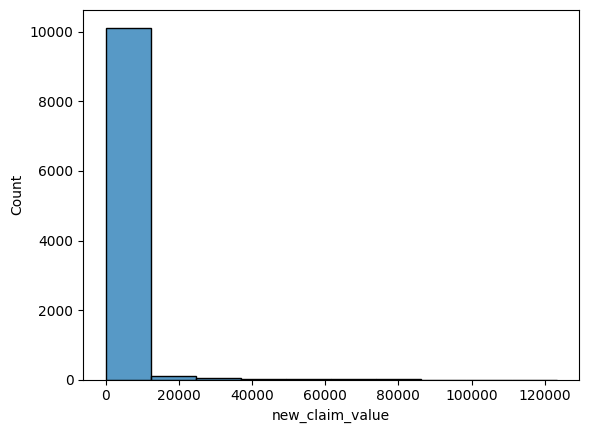

In [15]:
sns.histplot(data_df['new_claim_value'], bins = 10)

### Create a Stratified Split with non Linearly spaced bins to capture extreme values 

In [16]:
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]

labels = np.arange(1,12)

data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels = labels, include_lowest = True)

<Axes: ylabel='claim_value_cat'>

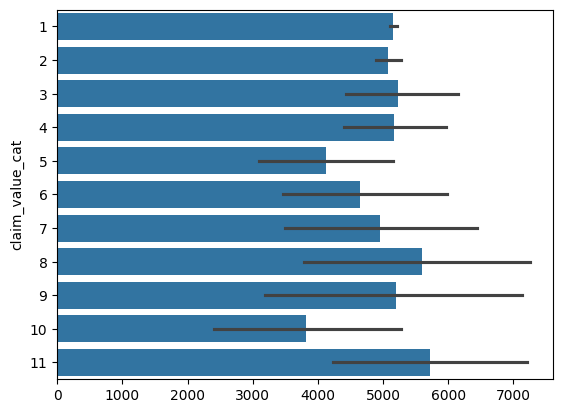

In [17]:
sns.barplot(data_df['claim_value_cat'])

### Important to have sufficient data in each stratum 

In [18]:
X = data_df.copy()
y = data_df['is_claim']

X.drop(columns=['new_claim_value', 'is_claim'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = X['claim_value_cat'])

### Check Positive / Negative class ratio for target data

In [19]:
train_ratio = round((y_train.sum() / len(y_train)) * 100, 2)
test_ratio = round((y_test.sum() / len(y_test) * 100), 2)

print(f"Train Positive class ratio: {train_ratio}%")
print(f"Test Positive class ratio: {test_ratio}%")

Train Positive class ratio: 26.48%
Test Positive class ratio: 27.37%


In [20]:
# Remove bins from each set
for set_ in (X_train, X_test):
    set_.drop(columns = ['claim_value_cat'], inplace = True)

# 2. Exploratory Data Analysis (EDA)

In [21]:
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [22]:
# Resolving Binary Cols
binary_cols = ['single_parent', 'married', 'gender','red_vehicle','licence_revoked']

mapping = {
    "Yes": 1,
    "No": 0,
    'yes': 1,
    'no': 0,
    'M': 1,
    'F': 0
}

def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

eda_test_data = binarize_values(eda_test_data, binary_cols, mapping)

In [23]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,licence_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


### Correlation Matrix with Heatmap

<Axes: >

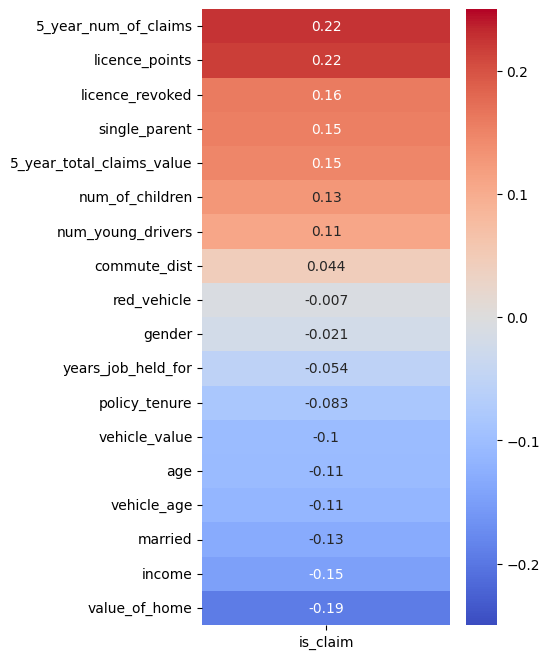

In [24]:
corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending = False)
corr_matrix = corr_matrix.drop('is_claim')

fig, ax = plt.subplots(figsize=(4,8))
sns.heatmap(corr_matrix[['is_claim']], cmap='coolwarm', annot=True, vmax=0.25, vmin = -0.25)

# Preprocessing

### Drop unnecessary Columns

In [25]:
X_train_raw = X_train.copy()

cols_to_drop = ['red_vehicle']

X_train_raw.drop(columns = cols_to_drop, axis = 1, inplace = True)

## Handling Missing values

In [26]:
X_train_raw.isnull().sum().sum()

np.int64(2418)

In [27]:
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
licence_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

# KNearest Neighbors Imputer

In [28]:
knn_imputer = KNNImputer(n_neighbors = 2)

numerical_cols_df = X_train_raw.select_dtypes(include = ['number'])
numerical_cols = numerical_cols_df.columns.tolist()

cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [29]:
# Numerical
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

### !Check Missing data got Imputed!

In [30]:
num_cols_df = X_train_raw[numerical_cols].reset_index(drop = True)

missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [31]:
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


In [32]:
# Categorical
simple_imputer = SimpleImputer(strategy = 'most_frequent')

def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

In [33]:
# Check imputation
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)

missing_data_df = cat_cols_df[cat_cols_df.isna().any(axis=1)]
missing_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,NaN,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,NaN,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,NaN,Commercial,Panel Truck,No,Highly Rural/ Rural


In [34]:
samples = missing_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
19,No,Yes,M,Masters,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban
36,No,Yes,F,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
69,Yes,No,M,Masters,Blue Collar,Commercial,Van,No,Highly Urban/ Urban
77,No,No,M,Masters,Blue Collar,Commercial,Pickup,No,Highly Rural/ Rural
78,No,Yes,M,PhD,Blue Collar,Commercial,Panel Truck,No,Highly Rural/ Rural


### Rejoin Numerical and Categorical

In [35]:
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis = 1)

train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban


In [36]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
value_of_home                0
commute_dist                 0
vehicle_value                0
policy_tenure                0
5_year_total_claims_value    0
5_year_num_of_claims         0
licence_points               0
vehicle_age                  0
single_parent                0
married                      0
gender                       0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
licence_revoked              0
address_type                 0
dtype: int64

# Categorical Feature Encoding

### i. Ordinal encoders
### ii. Binary Encoders
### iii. One Hot Encoders

In [37]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
licence_revoked      2
address_type         2
dtype: int64

In [38]:
cat_cols_ord = ['highest_education']
cat_cols_bin = ['single_parent','married','gender','type_of_use','licence_revoked','address_type']
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [39]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Ordinal
ord_encoder = OrdinalEncoder(categories = education_rank)
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Binary
bin_encoder = OrdinalEncoder()
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One Hot Encoder
one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [40]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

all_cat_encoded_df = pd.concat([ord_encoded_df,bin_encoded_df,one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [41]:
# Numerical and Categorical data back together

X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [42]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### !Check for the Dummy Variable Trap
Multi Co-Linearity

In [43]:
def calculate_vif(dataframe):
    df_with_constant = add_constant(dataframe)

    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_with_constant.columns
    vif_data['VIF'] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

    return vif_data

vif_df = calculate_vif(X_train_cleaned)
vif_df

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


In [44]:
# To solve the More_than_5_inf_values issue, 
# Drop reference category of the one hot encoded features
X_train_cleaned.drop(['occupation_Blue Collar', 'vehicle_type_Minivan'], axis=1, inplace = True)

In [45]:
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.124998
1,num_young_drivers,1.317458
2,age,1.470704
3,num_of_children,2.083100
4,years_job_held_for,1.437881
5,income,2.633292
6,value_of_home,2.120414
7,commute_dist,1.039162
8,vehicle_value,2.030342
9,policy_tenure,1.005861


# Model Selection - Classification

In [46]:
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state = 42)),\
    ('Linear SVM', LinearSVC(random_state = 42, max_iter = 1000, dual = 'auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [47]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

results = {}

for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv = kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Text(0.5, 1.0, 'Cross Validation Scores for Different Classifiers')

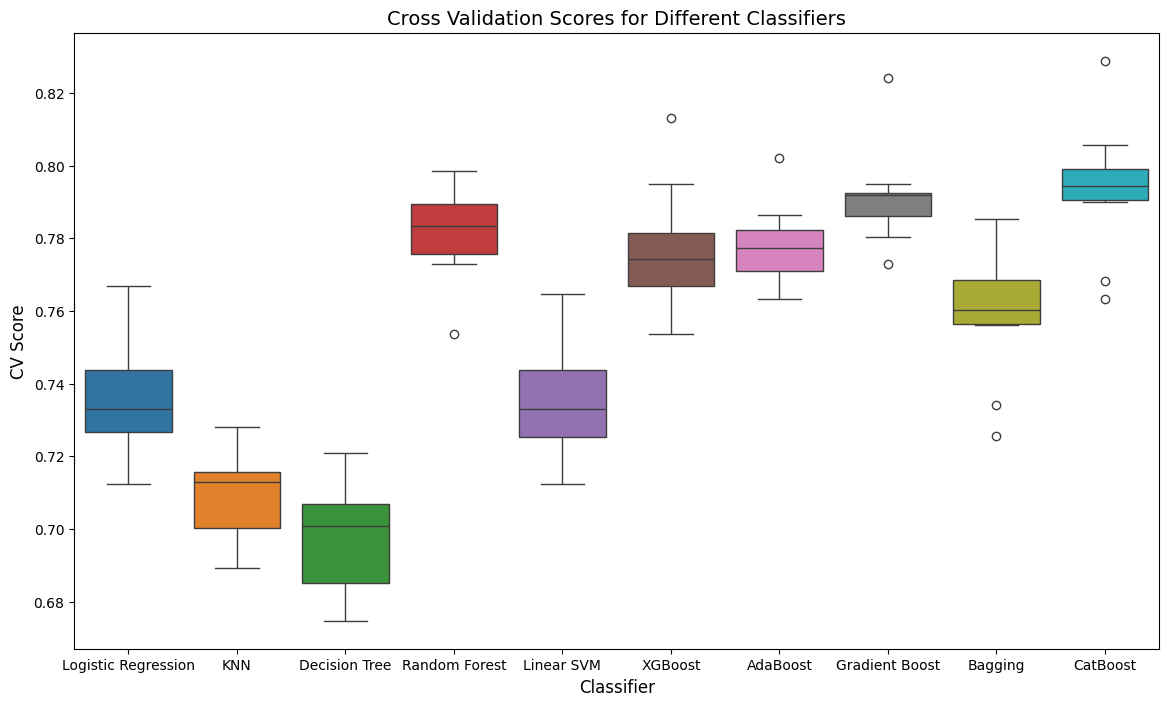

In [48]:
fig,ax = plt.subplots(figsize=(14,8))
sns.boxplot(cv_scores_df)

ax.set_xlabel("Classifier", fontsize = 12)
ax.set_ylabel("CV Score", fontsize = 12)
ax.set_title('Cross Validation Scores for Different Classifiers', fontsize = 14)

# Feature Engineering

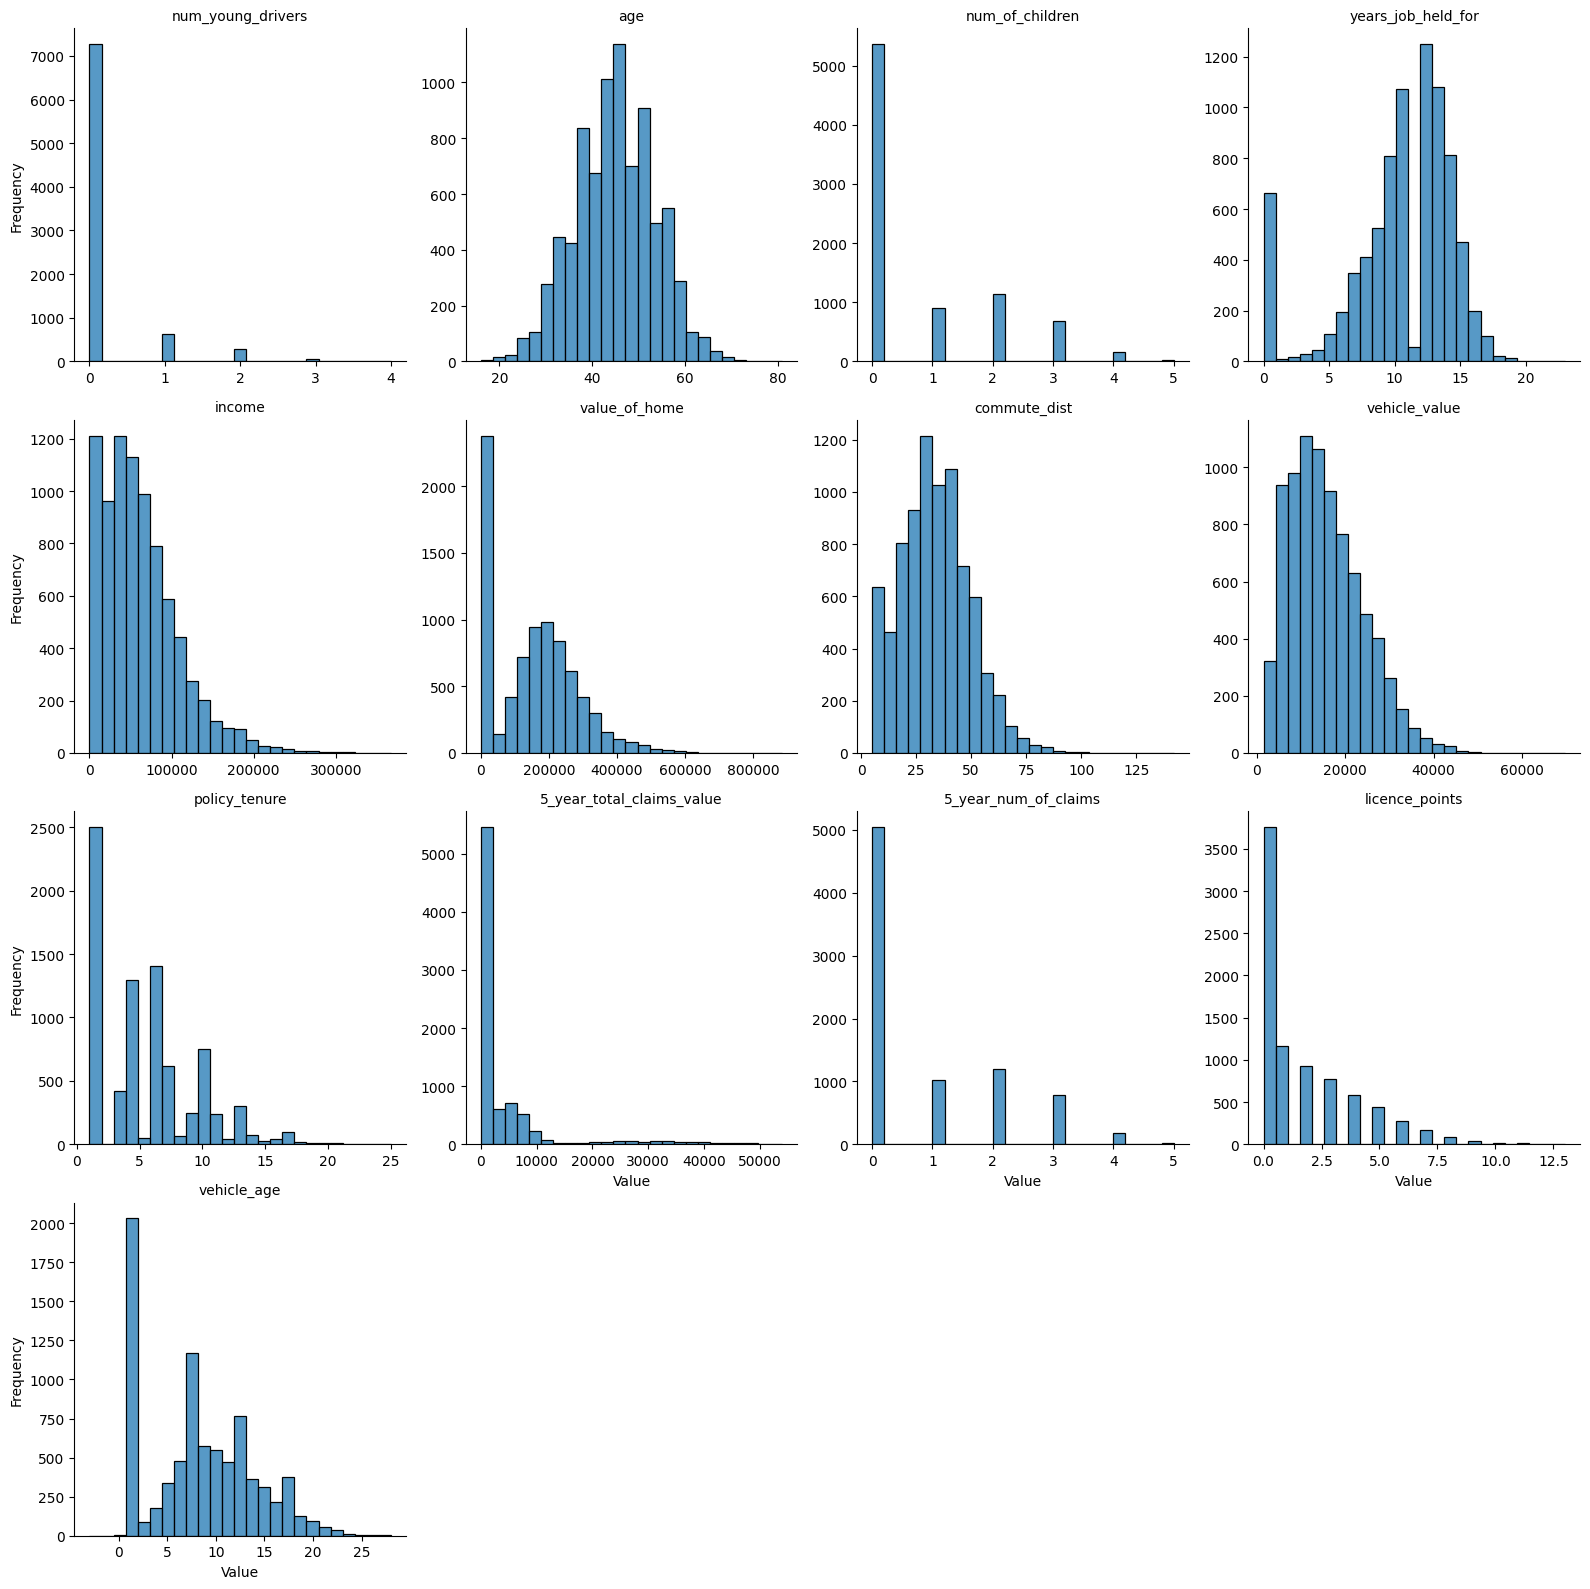

In [49]:
# Melt df to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

g = sns.FacetGrid(melted_X_train, col='Column', col_wrap = 4, sharex = False, sharey= False, height = 4)

g.map(sns.histplot,'Value', bins = 25)

g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template = '{col_name}')

plt.tight_layout()

### We can see Right Skewed nature to some columns
#### So we fix it by taking square root of those features

In [50]:
skewed_features = ['income','value_of_home','commute_dist','vehicle_value','policy_tenure','licence_points']

def sqrt_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

X_train_cleaned_sqrt = sqrt_of_feature(X_train_cleaned, skewed_features)

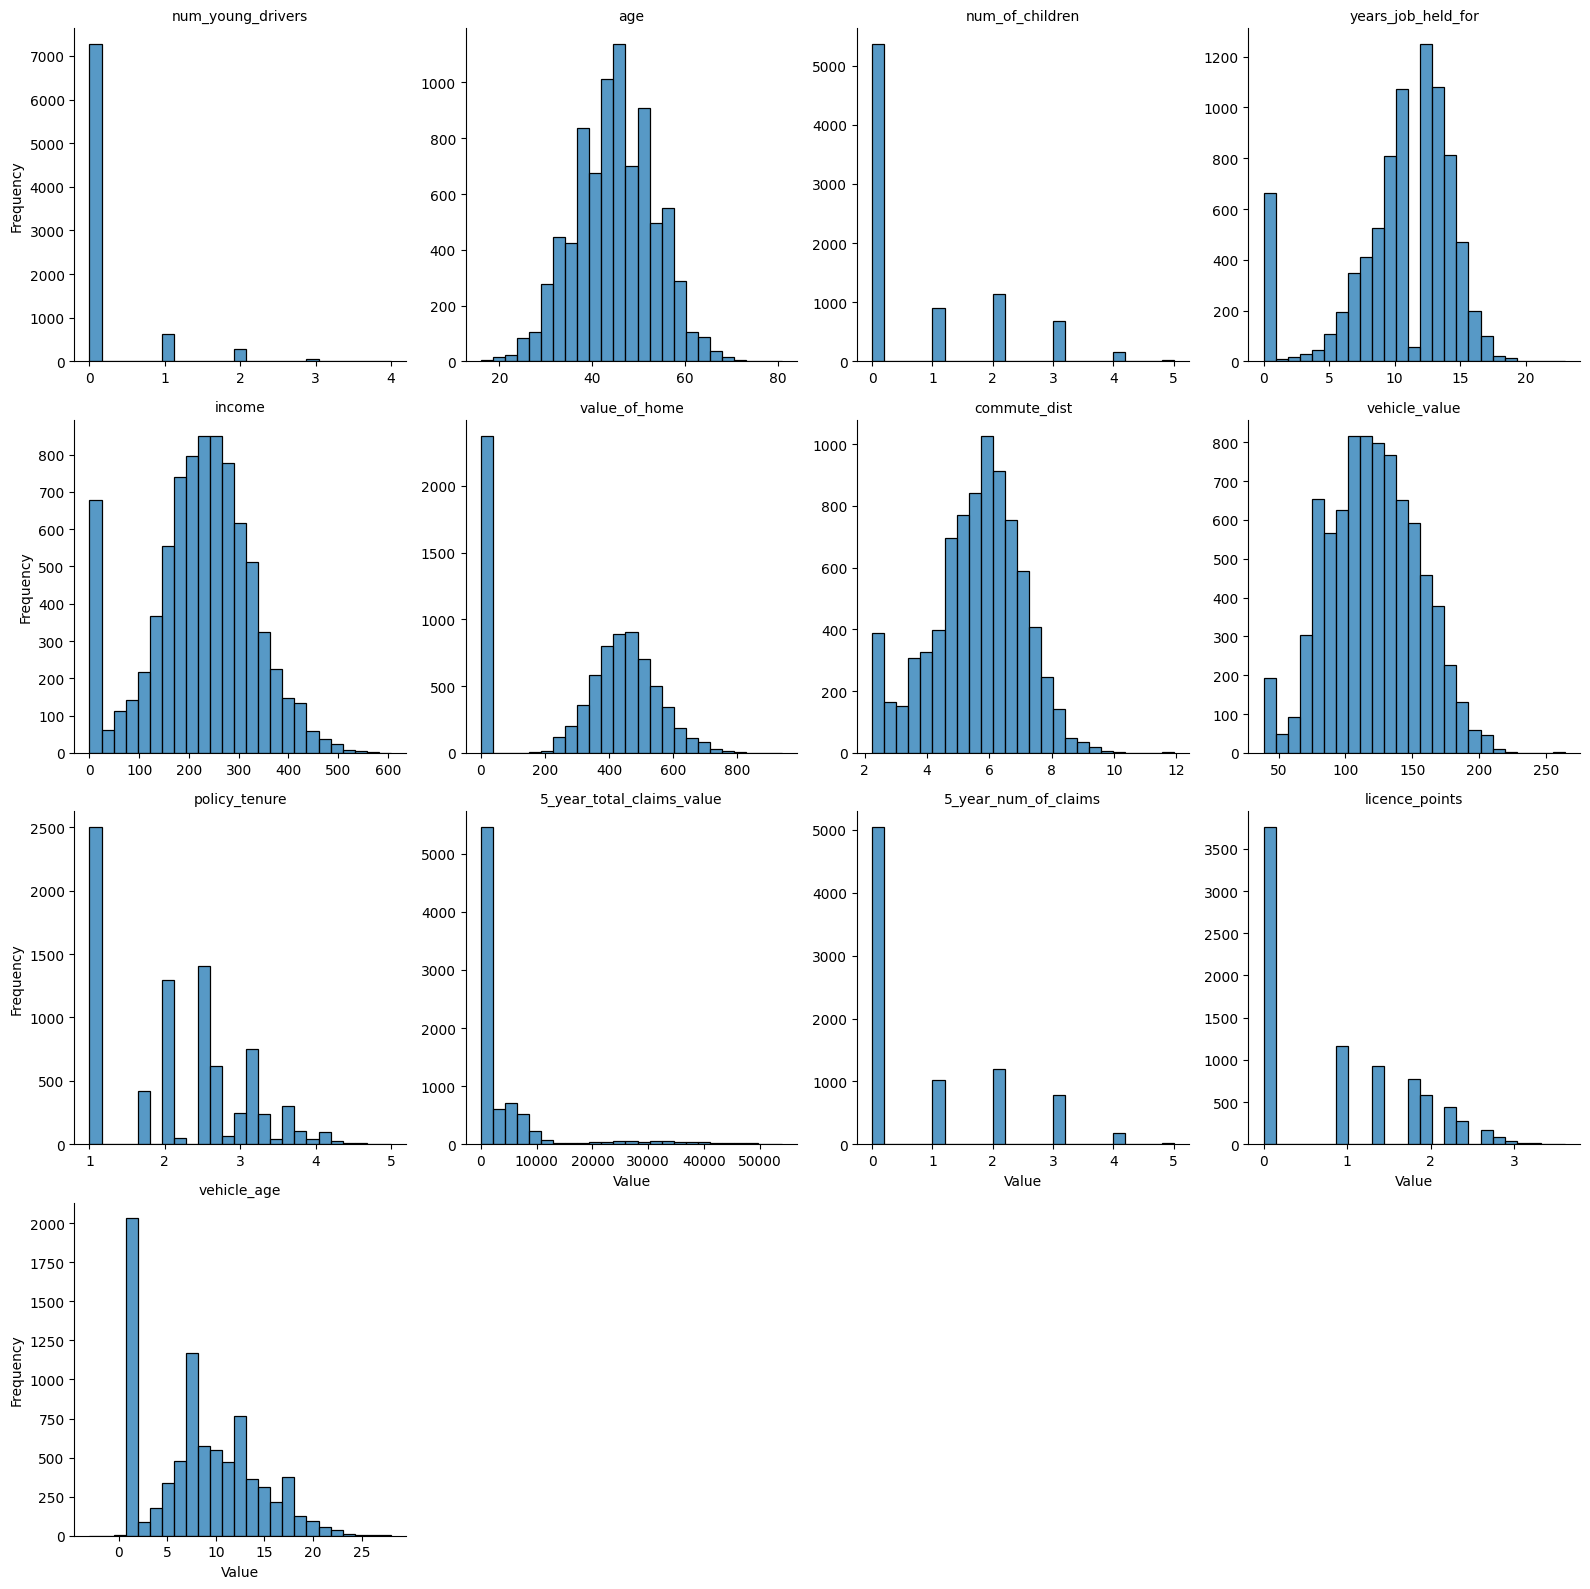

In [51]:
melted_X_train = X_train_cleaned_sqrt[numerical_cols].melt(var_name='Column', value_name='Value')

g = sns.FacetGrid(melted_X_train, col='Column', col_wrap = 4, sharex = False, sharey= False, height = 4)

g.map(sns.histplot,'Value', bins = 25)

g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template = '{col_name}')

plt.tight_layout()

In [52]:
xgb_clf = XGBClassifier(random_state=42)

# Without Sqrt
cv_scores = cross_val_score(xgb_clf, X_train_cleaned, y_train, cv = kf)
print(f"CV Score without sqrt transformation: {cv_scores.mean()}")

# With Sqrt
cv_scores_sqrt = cross_val_score(xgb_clf, X_train_cleaned_sqrt, y_train, cv=kf)
print(f"CV Score with sqrt transformation: {cv_scores_sqrt.mean()}")

CV Score without sqrt transformation: 0.7770631067961167
CV Score with sqrt transformation: 0.7770631067961167


# Feature Scaling

In [53]:
def scale_features(data_df, numeric_features):
    data = data_df.copy()

    scaler = StandardScaler()
    scaler.fit(data[numeric_features])
    data[numeric_features] = scaler.transform(data[numeric_features])
    
    return data

X_train_cleaned_scaled = scale_features(X_train_cleaned_sqrt, numerical_cols)

In [54]:
xgb_clf = XGBClassifier(random_state = 42)

# Without Scaled
cv_scores = cross_val_score(xgb_clf, X_train_cleaned, y_train, cv = kf)
print(f"CV Score without Scaled transformation: {cv_scores.mean()}")

# With Scaled
cv_scores_scaled = cross_val_score(xgb_clf, X_train_cleaned_scaled, y_train, cv=kf)
print(f"CV Score with Scaled transformation: {cv_scores_scaled.mean()}")

CV Score without Scaled transformation: 0.7770631067961167
CV Score with Scaled transformation: 0.7770631067961167


In [55]:
X_train_scaled = X_train_cleaned_scaled.copy()

# Model Pipeline

### Custom Transformers

In [56]:
# 1]Transformer to drop red vehicle Column
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns = self.columns_to_drop)

    def get_feature_names_out(self, input_features = None):
        return None

In [57]:
# 2]Transformer to take square root of features
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features = None):
        return input_features

In [58]:
# Pipeline
from sklearn import set_config
set_config(transform_output = "pandas")

cols_to_drop = ['red_vehicle']
cols_to_drop_pipeline = Pipeline([
        ('col_dropper', ColumnDropper(cols_to_drop))
    ])

skewed_features = ['income', 'value_of_home','commute_dist','vehicle_value','policy_tenure','licence_points']

num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors = 2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler())
])

education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories = education_rank))
])

cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('binary_encoder', OrdinalEncoder())
])

cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot)
])

In [59]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

### Check the pipeline output is correct by checking it against the DataFrame we built manually.

In [60]:
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns = preprocess_pipeline.get_feature_names_out()
)

one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

X_train_prepared_df.columns = new_col_names

X_train_prepared_df.reset_index(drop = True, inplace = True)

X_train_prepared_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332668,1.409817,-0.643344,-2.563674,-0.375723,-1.452458,0.498062,-1.040804,1.139483,-0.461230,-0.691403,0.092242,-1.295667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.669060,-0.453096,2.054902,0.874127,-0.866152,0.037836,-0.479232,-1.159364,-0.142286,-0.461230,-0.691403,0.878344,-1.295667,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.332668,-1.850281,1.155487,0.383013,0.090791,0.424047,0.443522,-2.392885,-0.142286,0.161972,0.177994,1.419574,-0.405338,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332668,0.129064,0.256071,0.628570,0.258015,0.569484,-0.929180,0.845452,-1.245093,0.147137,0.177994,1.648754,-0.405338,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332668,-0.685960,-0.643344,-0.599216,1.093996,1.062875,-0.409978,-1.374057,-1.245093,-0.461230,-0.691403,0.092242,-0.583403,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [61]:
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,licence_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [62]:
X_train_cleaned.equals(X_train_prepared_df)

False

# HyperParameter Optimization

### Randomized SearchCV

In [63]:
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth':randint(low=1,high=20),
    'subsample':uniform(0,1),
    'colsample_bytree':uniform(0,1),
    'min_child_weight':randint(low=1,high=20),
    'reg_alpha':randint(low=0, high=100),
    'reg_lambda':randint(low=0,high=10),
    'gamma':uniform(0,1)
}

xgb_model = XGBClassifier(random_state = 42, eval_metric = 'error')

scorer = make_scorer(f1_score, average = 'weighted')

random_search = RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = xgb_param_grid,
    n_iter = 2000,
    scoring = scorer,
    cv = 5,
    verbose = 1,
    random_state = 42,
    n_jobs = -1

)

In [64]:
random_search.fit(X_train_prepared, y_train)

print(f'Best Parameters found: {random_search.best_params_}')
print(f'Best Cross-Validation Score: {random_search.best_score_}')

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best Parameters found: {'colsample_bytree': np.float64(0.9503797514820932), 'gamma': np.float64(0.9583276864813868), 'learning_rate': np.float64(0.03833510986215996), 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': np.float64(0.9860674802096018)}
Best Cross-Validation Score: 0.783837490334278


### Grid SearchCV

In [65]:
xgb_param_grid_grid_search = {
    'n_estimators': [280, 290, 300],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5, 0.55, 0.6],
    'gamma': [0.05, 0.1, 0.15],
    'min_child_weight': [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [66]:
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 18, 'n_estimators': 280, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.45}
Best cross-validation score:  0.7837470625729062


In [67]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7770631067961167
XGBoost model score (tuned hyperparamters: 0.7837470625729062


# Model Evaluation

In [68]:
# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [69]:
f1_score(y_test, y_pred, average='weighted')

0.7732777652550595

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

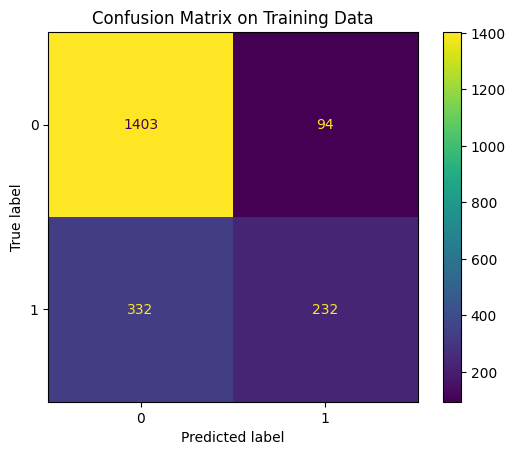

In [70]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')

## Regression

In [71]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [72]:
# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

In [75]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

In [90]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

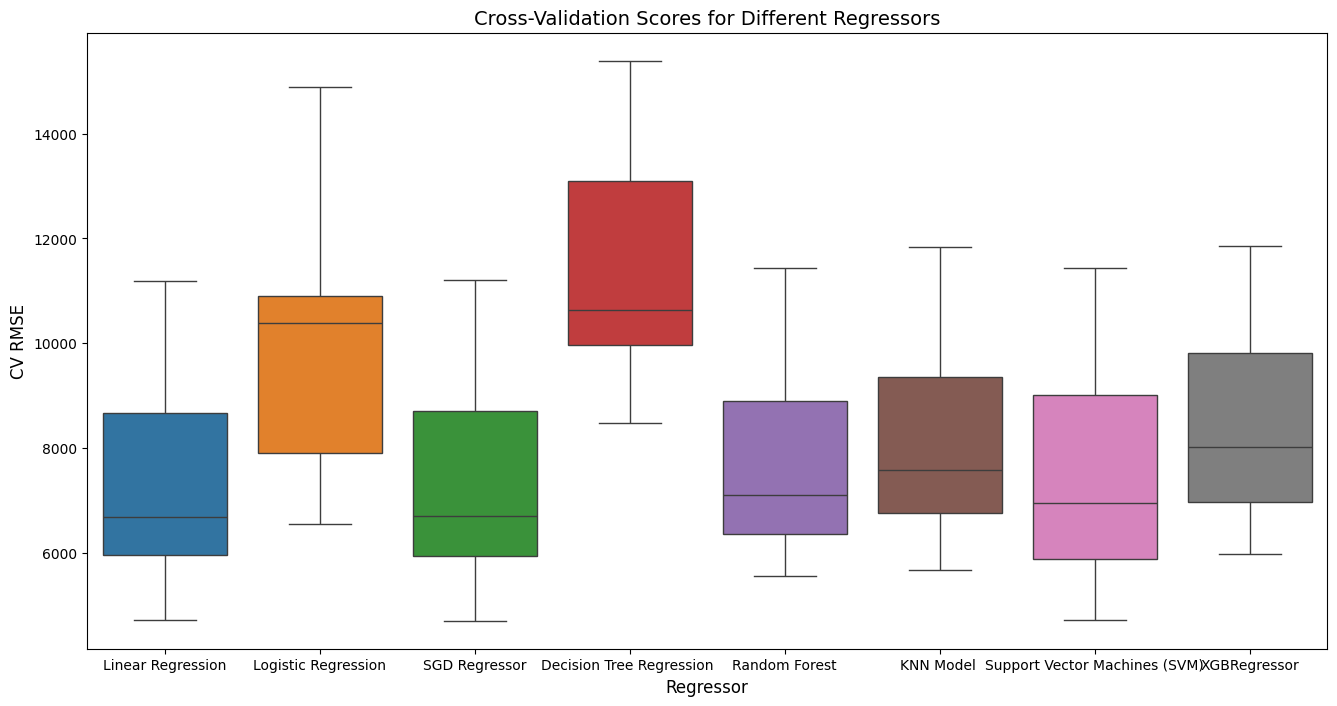

In [91]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

As we're using the RMSE as the scoring method, lower is better. We can see the linear regression and SGD Regressor models performed the best. Their scores were very similar, as the models themselves are. As we have more flexibility to tune the SGD Regressor, we'll proceed with that.

In [92]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [94]:
# Fit the model using RandomizedSearchCV
reg_random_search.fit(X_reg_train_prepared, y_reg_train)

score = np.sqrt(-random_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", score)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9503797514820932), 'gamma': np.float64(0.9583276864813868), 'learning_rate': np.float64(0.03833510986215996), 'max_depth': 15, 'min_child_weight': 14, 'n_estimators': 294, 'reg_alpha': 0, 'reg_lambda': 8, 'subsample': np.float64(0.9860674802096018)}
Best cross-validation score:  nan


/tmp/ipykernel_55/2748580657.py:4: RuntimeWarning: invalid value encountered in sqrt
  score = np.sqrt(-random_search.best_score_)


In [95]:
# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.004, 0.008, 0.012],
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.003, 0.005],
    'max_iter': [180, 200, 220],
    'tol': [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [96]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stocha

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stocha

Best parameters found:  {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}
Best cross-validation score:  7605.2923588743715


In [97]:
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 8378.846093356431
MAE: 3556.2627508324217


We can see the RMSE score was slightly higher than what we saw in the train sets, but still fairly inline. As with the classification model, there is still lots of room for potential improvement, like additional feature engineering, investigating feature importance or combining multiple models to create an ensemble